In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import rcParams
from skimage.morphology import binary_dilation, medial_axis
from skimage.filters import gaussian
from skimage.measure import label, regionprops
from skimage.draw import line
import skimage.io

import sys
sys.path.append('../')

import utilities as ut

FILENAME = '1V-15Hz'
THRESHOLD = 100
MAX_PIXEL_VALUE = 255

plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (20, 15)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
# rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

### Tratamiento de un frame

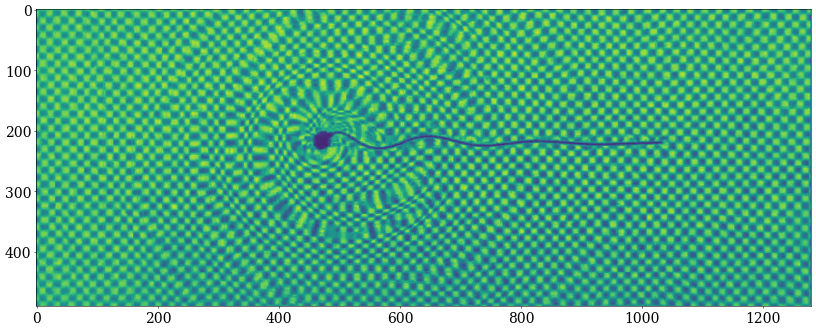

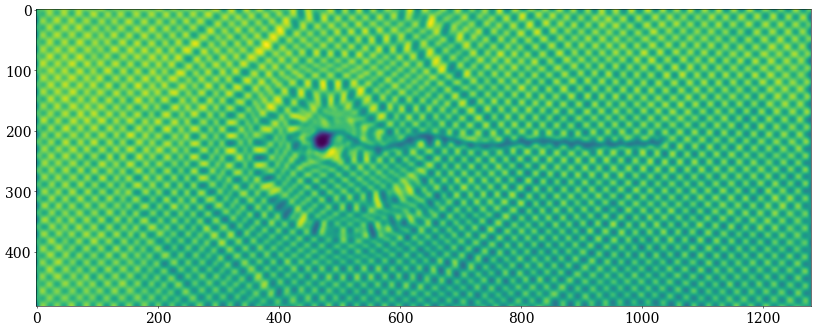

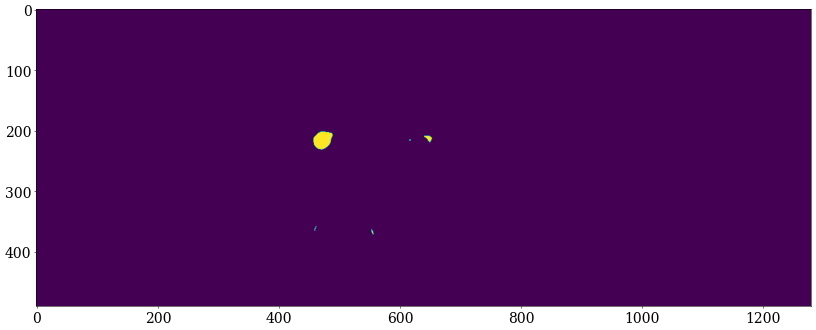

In [94]:
frame = skimage.io.imread(f'example_media\\captura-{FILENAME}.tiff')
frame_copy = frame.copy()
frame_gray = ut.gris(frame)
plt.figure()
plt.imshow(frame_gray)

frame_gaussian = gaussian(frame_gray, 4)
plt.figure()
plt.imshow(frame_gaussian)

frame_binary = 255 - ut.binarize_gray(frame_gaussian, threshold=0.45)
plt.figure()
plt.imshow(frame_binary)

Si se cortaron bien los bordes y se aplican los filtros adecuados el objeto más grande en la imagen en todos los frames donde aparece debería ser siempre la cabeza (asumiendo que usamos un threshold que filtra correctamente la cola), siempre que esté en cuadro. Los cuadrados del patrón son de bastante menor área en píxeles, lo que nos permite descartar frames de análisis donde no encontremos un objeto del tamaño suficiente. Esto es lo que usamos para considerar sólo los frames donde obervamos al nadador.

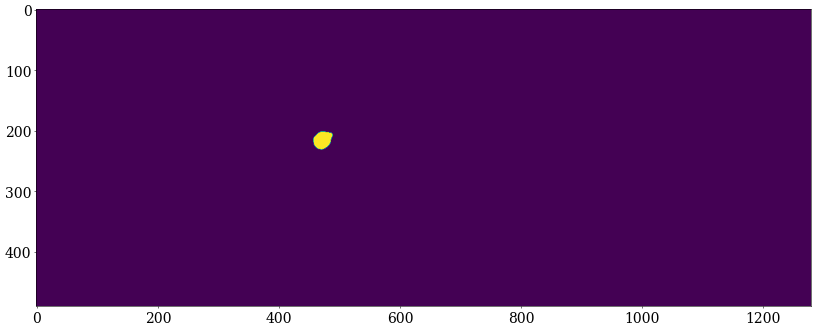

In [95]:
# elegimos objeto de el de mayor área en píxeles
labeled_image = label(1-frame_binary, connectivity=1)
object_features = regionprops(labeled_image)
object_areas = [objf["area"] for objf in object_features]
object_centroid = [objf["centroid"] for objf in object_features]
n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]

# creamos una máscara para conservar sólo ese objeto de mayor área
mask = np.zeros_like(labeled_image)
mask += (labeled_image==n+1).astype(int)
area  =  255 * mask
plt.figure()
plt.imshow(area)

# obtenemos las coordenadas del centroide (no es una figura regular) de ese objeto como parte de las propiedades de los objetos
y_centroid, x_centroid = object_centroid[n]
y, x = np.where(area!=0)
blob_mask = np.zeros_like(frame_gray)
blob_mask[y, x] = 1

Volvemos a cargar la imagen, esta vez para recuperar la forma de la cola, que necesitamos para poder obtener la forma de la cabeza.

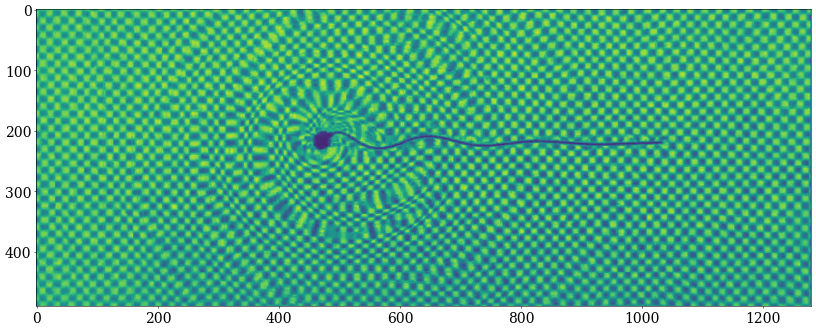

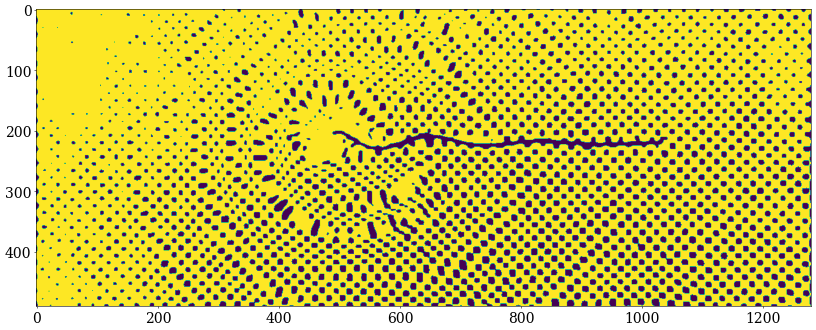

In [96]:
frame = skimage.io.imread(f'example_media\\captura-{FILENAME}.tiff')
frame_copy = frame
frame_gray = ut.gris(frame)
plt.figure()
plt.imshow(frame_gray)

head = np.where(binary_dilation(binary_dilation(blob_mask))!=0)

frame_gray[head] = np.mean(frame_gray)

# uso los parámetros que funcionan para este video
frame_gaussian = gaussian(frame_gray, 2)*255
_, frame_binary = cv.threshold(frame_gaussian, 140, MAX_PIXEL_VALUE, cv.THRESH_BINARY)

plt.figure()
plt.imshow(frame_binary)

Enmascarando la cabeza, si preprocesamos bien la imagen el objeto más grande en todos los frames debería ser la cola

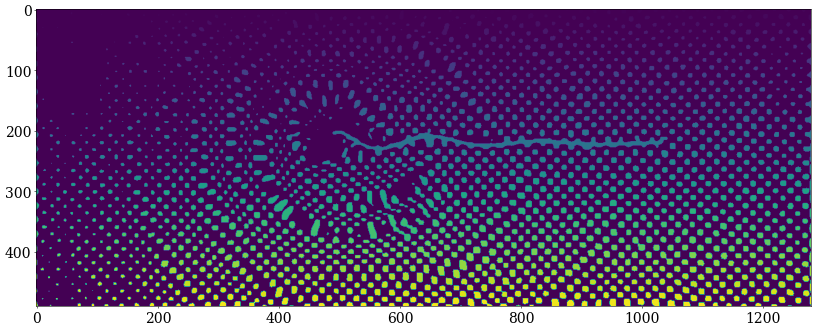

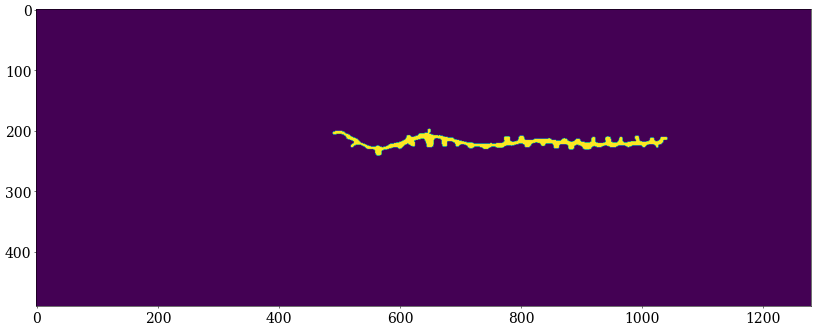

In [98]:
labeled_image = label(1-frame_binary, connectivity=1)
object_features = regionprops(labeled_image)
object_areas = [objf["area"] for objf in object_features]
n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
mask = np.zeros_like(labeled_image)
mask += (labeled_image==n+1).astype(int)
area  =  mask
plt.figure()
plt.imshow(labeled_image)

plt.figure()
plt.imshow(area)

ref_sk, dist = medial_axis(mask, return_distance=True)
tail = np.where(area!=0)                

y_sk, x_sk = np.where(ref_sk!=0)

Para tener la posición de referencia de la cabeza que queremos, guardamos el punto del extremo izquierdo del esqueleto del cuerpo recuperado (rosa), lo que sería el cuello del filamento. Con la función _line()_ trazamos una línea (azul) en la dirección que une el centro y el cuello hasta un punto más sobre la misma (azul), más o menos a un diámetro de la cabeza de distancia con el centro. Obtenemos la posición de la cabeza como el punto donde esa línea cruza la frontera de la cabeza (rojo).

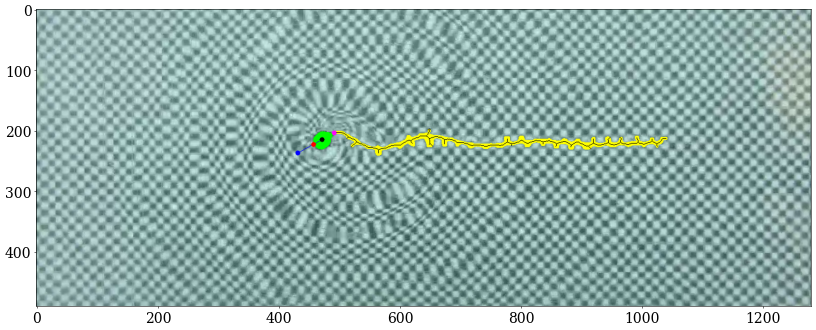

In [ ]:
# coordenadas del centro de la cabeza en la imagen
frame1 = skimage.io.imread(f'example_media\\captura-{FILENAME}.tiff')
frame1[np.where(blob_mask!=0)] = [0, 255, 0]
x_c, y_c = int(x_centroid), int(y_centroid)
frame1 = cv.circle(frame1, (x_c, y_c), radius=1, color=(0, 0, 0), thickness=5)

# coordenadas de la unión del filamento con la cabeza 
x_neck, y_neck = np.min(x_sk), y_sk[np.where(x_sk == np.min(x_sk))[0][0]]
frame1[tail] = [255, 255, 0]
frame1[y_sk, x_sk] = [0,0,0]
frame1 = cv.circle(frame1, (x_neck, y_neck), radius=1, color=(255, 0, 255), thickness=5)

x_line = x_c + 2*(x_c-x_neck)
y_line = y_c + 2*(y_c-y_neck)
rr, cc = line(x_c, y_c, x_line, y_line)
y_head, x_head = cc[np.where(blob_mask[cc, rr]==0)[0][0]], rr[np.where(blob_mask[cc, rr]==0)[0][0]]

# eje
frame1[cc, rr] = [0,0, 255]
# fin del eje
frame1 = cv.circle(frame1, (x_line, y_line), radius=1, color=(0, 0, 255), thickness=5)
frame1 = cv.circle(frame1, (x_c, y_c), radius=1, color=(0, 0, 0), thickness=5)
# pos de la cabeza
frame1 = cv.circle(frame1, (x_head, y_head), radius=1, color=(255, 0, 0), thickness=5)
plt.figure()
plt.imshow(frame1)